In [1]:
pip install darts

Note: you may need to restart the kernel to use updated packages.


In [2]:
# imports time series
import pandas as pd
import numpy as np
import random

# plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# para calculas métricas del modelo
from sklearn.metrics import mean_squared_error

# misc
import os
import glob
import time
import itertools
import warnings
warnings.filterwarnings("ignore")
from datetime import timedelta, datetime

# apartado ts
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pmdarima as pm

# darts
from darts import TimeSeries
from itertools import product

In [5]:
# Cargar datos agrupados a nivel semana
df_final = pd.read_csv('/Users/anapeyra/Desktop/NUCLIO/Entregables/TFM/stock-prediction-dsmarket/data_dsmarket/interim/df_forecast_1.csv')

In [6]:
df_final.shape

(8323770, 41)

In [7]:
df_final.head()

,Unnamed: 0,date,year,month,month_int,week,year_week,day,weekday,weekday_int,...,event_Ramadan_sales,event_NewYear_sales,event_Easter_sales,sales_2011,sales_2012,sales_2013,sales_2014,sales_2015,sales_2016,sales_2015_rel
0,0,2011-01-31,2011,January,1,5,2011-5,31,Monday,3,...,0,0,0,0,0,0,0,0,0,0
1,1,2011-02-07,2011,February,2,6,2011-6,7,Monday,3,...,0,0,0,0,0,0,0,0,0,0
2,2,2011-02-14,2011,February,2,7,2011-7,14,Monday,3,...,0,0,0,0,0,0,0,0,0,0
3,3,2011-02-21,2011,February,2,8,2011-8,21,Monday,3,...,0,0,0,0,0,0,0,0,0,0
4,4,2011-02-28,2011,February,2,9,2011-9,28,Monday,3,...,0,0,0,0,0,0,0,0,0,0


In [8]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8323770 entries, 0 to 8323769
Data columns (total 41 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   Unnamed: 0                int64  
 1   date                      object 
 2   year                      int64  
 3   month                     object 
 4   month_int                 int64  
 5   week                      int64  
 6   year_week                 object 
 7   day                       int64  
 8   weekday                   object 
 9   weekday_int               int64  
 10  event_any                 int64  
 11  event_SuperBowl           int64  
 12  event_Thanksgiving        int64  
 13  event_Ramadan             int64  
 14  event_NewYear             int64  
 15  event_Easter              int64  
 16  id                        object 
 17  item                      object 
 18  category                  object 
 19  department                object 
 20  store                   

In [9]:
df_final["weekday"].value_counts()

weekday
Monday    8323770
Name: count, dtype: int64

In [10]:
df_final["date"].nunique() #semanas

#P.S. Originalmente eran 274, pero la primera tenia datos incompletos, así que se eliminó previamente en preprocessing.

273

### Encontrar los productos más vendidos (top20) por store

Como definimos los productos más vendidos?
* Qué unidades usamos de referencia? **units** / sales
* Qué periodo tomamos de referencia? **todo** / último año

In [11]:
# Seleccionar las columans relevantes para el problema
df = df_final[["date",
               "year",
              "year_week",
              "id",
              "item",
              "department",
              "category",
              "store",
              "store_code",
              "region",
              "units"]]

df.head()

,date,year,year_week,id,item,department,category,store,store_code,region,units
0,2011-01-31,2011,2011-5,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES_1,ACCESORIES,South_End,BOS_1,Boston,0
1,2011-02-07,2011,2011-6,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES_1,ACCESORIES,South_End,BOS_1,Boston,0
2,2011-02-14,2011,2011-7,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES_1,ACCESORIES,South_End,BOS_1,Boston,0
3,2011-02-21,2011,2011-8,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES_1,ACCESORIES,South_End,BOS_1,Boston,0
4,2011-02-28,2011,2011-9,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES_1,ACCESORIES,South_End,BOS_1,Boston,0


In [12]:
# Transformar "date" de object -> datetime64[ns]
df["date"] = pd.to_datetime(df["date"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8323770 entries, 0 to 8323769
Data columns (total 11 columns):
 #   Column      Dtype         
---  ------      -----         
 0   date        datetime64[ns]
 1   year        int64         
 2   year_week   object        
 3   id          object        
 4   item        object        
 5   department  object        
 6   category    object        
 7   store       object        
 8   store_code  object        
 9   region      object        
 10  units       int64         
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 698.6+ MB


In [13]:
# Agrupa por tienda y producto, y calcula el total de ventas
units_per_store_item = df.groupby(['store_code', 'id'])['units'].sum().reset_index()
units_per_store_item = units_per_store_item.sort_values(['units'], ascending=False).reset_index(drop=True)
units_per_store_item

,store_code,id,units
0,NYC_3,SUPERMARKET_3_090_NYC_3,250262
1,BOS_2,SUPERMARKET_3_586_BOS_2,192652
2,BOS_3,SUPERMARKET_3_586_BOS_3,149891
3,NYC_3,SUPERMARKET_3_586_NYC_3,134275
4,NYC_1,SUPERMARKET_3_090_NYC_1,126914
...,...,...,...
30485,BOS_3,SUPERMARKET_2_071_BOS_3,16
30486,PHI_2,SUPERMARKET_2_057_PHI_2,16
30487,PHI_3,ACCESORIES_1_170_PHI_3,13
30488,NYC_2,SUPERMARKET_3_778_NYC_2,12


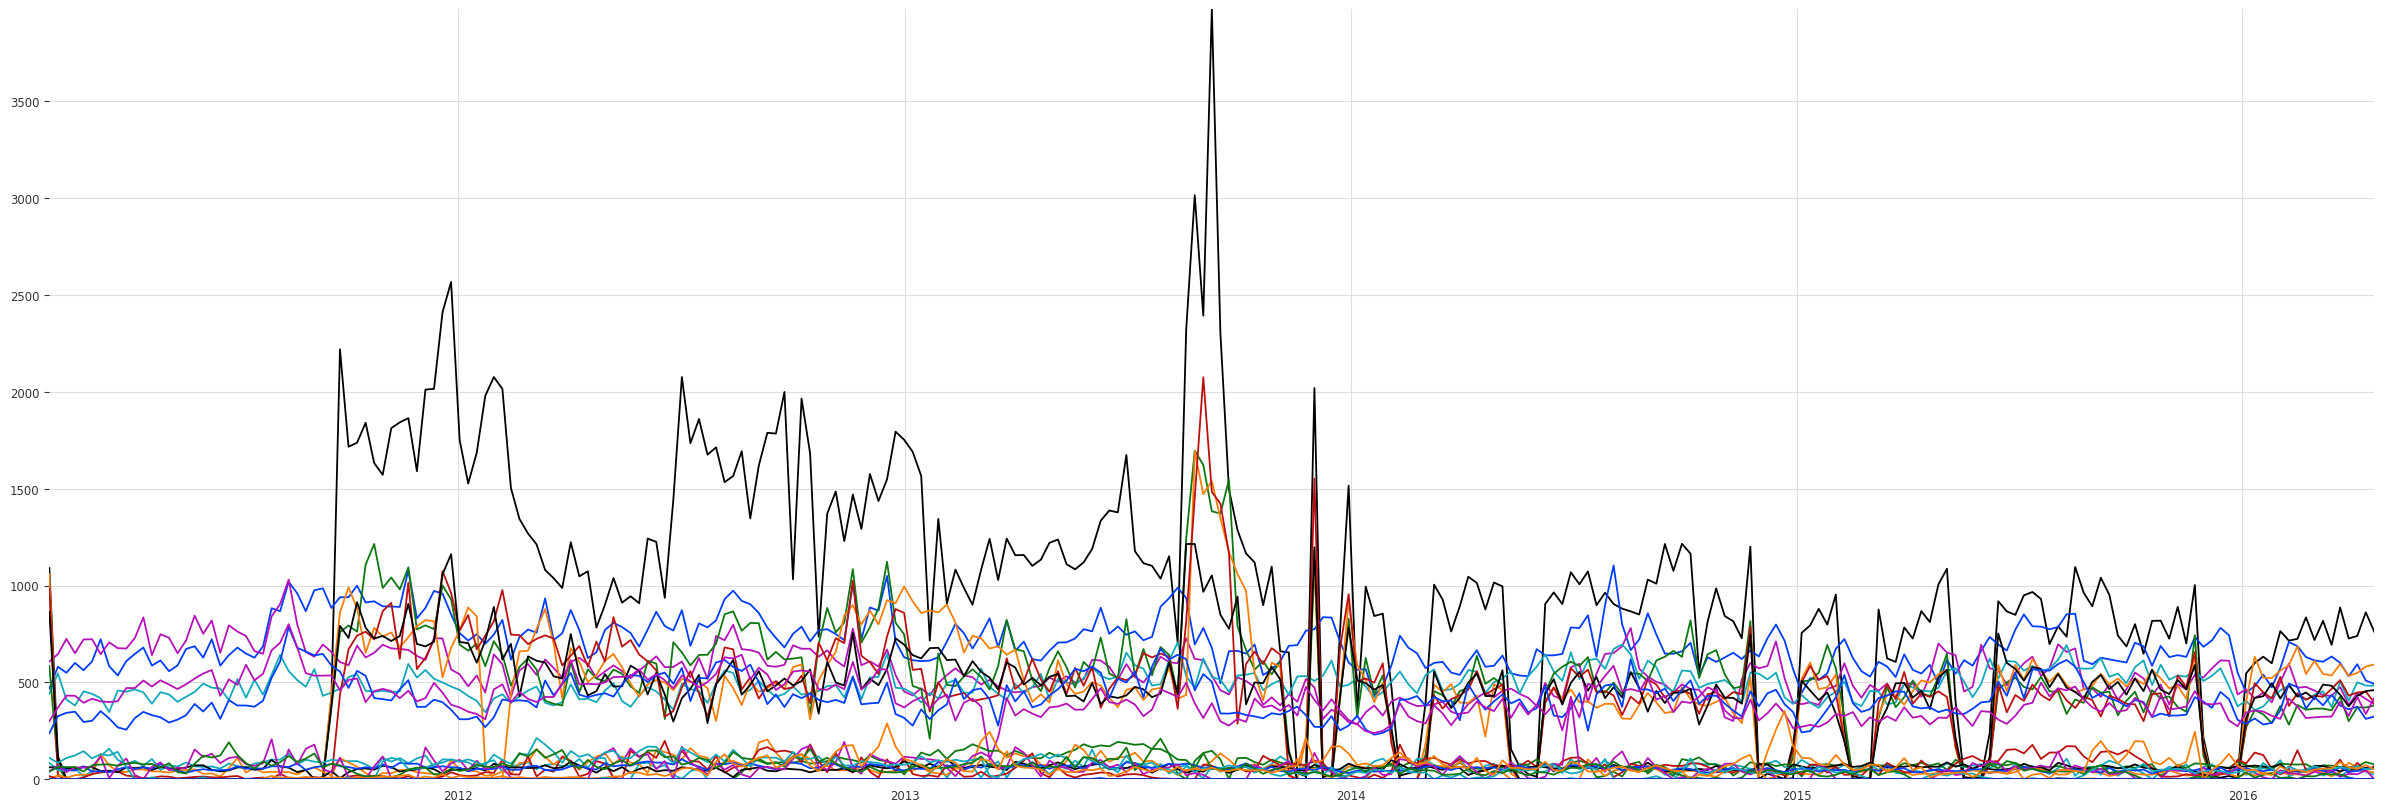

In [14]:
# Ejemplos de las time series de los ids más vendidos, los promedio y los menos vendidos.
fig, ax = plt.subplots(figsize=(30, 10))

for single_ts in list(np.arange(0, 10)) + list(np.arange(500, 510)) + list(np.arange(30480, 30490)):
    single_ts_df = pd.merge(df, 
                            units_per_store_item.loc[[single_ts], ['store_code', 'id']], 
                            how='inner', 
                            on=['store_code', 'id'])
    ax.plot(single_ts_df['date'], single_ts_df['units'], alpha=1)
    
ax.set_xlim([df['date'].min(), df['date'].max()])
ax.set_ylim([0, df['units'].max()])
plt.show()

In [15]:
# Para cada tienda, identifica los 20 productos más vendidos
top20_units_per_store_item = units_per_store_item.sort_values(['store_code','units'], ascending=False).reset_index(drop=True)
top20_units_per_store_item = top20_units_per_store_item.groupby('store_code').apply(lambda x: x.nlargest(20, 'units')).reset_index(drop=True)
top20_units_per_store_item.sort_values(['units'], ascending=False).reset_index(drop=True)
top20_units_per_store_item

,store_code,id,units
0,BOS_1,SUPERMARKET_3_586_BOS_1,112355
1,BOS_1,SUPERMARKET_3_090_BOS_1,93555
2,BOS_1,SUPERMARKET_3_555_BOS_1,69456
3,BOS_1,SUPERMARKET_3_252_BOS_1,56216
4,BOS_1,SUPERMARKET_3_587_BOS_1,48223
...,...,...,...
195,PHI_3,SUPERMARKET_3_547_PHI_3,31349
196,PHI_3,SUPERMARKET_2_360_PHI_3,30320
197,PHI_3,SUPERMARKET_3_752_PHI_3,29721
198,PHI_3,SUPERMARKET_3_202_PHI_3,29595


In [16]:
# Obtener una lista única de IDs
top20_id_list = top20_units_per_store_item['id'].unique()
top20_id_list

array(['SUPERMARKET_3_586_BOS_1', 'SUPERMARKET_3_090_BOS_1',
       'SUPERMARKET_3_555_BOS_1', 'SUPERMARKET_3_252_BOS_1',
       'SUPERMARKET_3_587_BOS_1', 'SUPERMARKET_3_714_BOS_1',
       'SUPERMARKET_3_202_BOS_1', 'SUPERMARKET_3_694_BOS_1',
       'SUPERMARKET_3_723_BOS_1', 'SUPERMARKET_3_607_BOS_1',
       'SUPERMARKET_3_377_BOS_1', 'SUPERMARKET_3_681_BOS_1',
       'SUPERMARKET_2_181_BOS_1', 'SUPERMARKET_3_226_BOS_1',
       'SUPERMARKET_3_541_BOS_1', 'SUPERMARKET_3_808_BOS_1',
       'SUPERMARKET_3_455_BOS_1', 'SUPERMARKET_3_234_BOS_1',
       'SUPERMARKET_3_462_BOS_1', 'SUPERMARKET_3_635_BOS_1',
       'SUPERMARKET_3_586_BOS_2', 'SUPERMARKET_3_090_BOS_2',
       'SUPERMARKET_3_252_BOS_2', 'SUPERMARKET_3_555_BOS_2',
       'SUPERMARKET_3_377_BOS_2', 'SUPERMARKET_3_587_BOS_2',
       'SUPERMARKET_3_714_BOS_2', 'SUPERMARKET_1_218_BOS_2',
       'SUPERMARKET_3_202_BOS_2', 'SUPERMARKET_3_030_BOS_2',
       'SUPERMARKET_3_080_BOS_2', 'SUPERMARKET_3_099_BOS_2',
       'SUPERMARKET_3_60

In [17]:
# Filtrar el df inicial con nuestros top20 items:
df_top20 = df[df["id"].isin(top20_id_list)]
df_top20.sort_values(by="date", ascending=True, inplace=True)
df_top20

,date,year,year_week,id,item,department,category,store,store_code,region,units
473928,2011-01-31,2011,2011-5,ACCESORIES_1_178_NYC_4,ACCESORIES_1_178,ACCESORIES_1,ACCESORIES,Brooklyn,NYC_4,New York,95
7729176,2011-01-31,2011,2011-5,SUPERMARKET_3_607_BOS_3,SUPERMARKET_3_607,SUPERMARKET_3,SUPERMARKET,Back_Bay,BOS_3,Boston,0
7729995,2011-01-31,2011,2011-5,SUPERMARKET_3_607_NYC_3,SUPERMARKET_3_607,SUPERMARKET_3,SUPERMARKET,Tribeca,NYC_3,New York,0
5969964,2011-01-31,2011,2011-5,SUPERMARKET_2_360_PHI_2,SUPERMARKET_2_360,SUPERMARKET_2,SUPERMARKET,Yorktown,PHI_2,Philadelphia,0
7805070,2011-01-31,2011,2011-5,SUPERMARKET_3_635_BOS_1,SUPERMARKET_3_635,SUPERMARKET_3,SUPERMARKET,South_End,BOS_1,Boston,51
...,...,...,...,...,...,...,...,...,...,...,...
7672391,2016-04-18,2016,2016-16,SUPERMARKET_3_586_NYC_1,SUPERMARKET_3_586,SUPERMARKET_3,SUPERMARKET,Greenwich_Village,NYC_1,New York,268
7672118,2016-04-18,2016,2016-16,SUPERMARKET_3_586_BOS_3,SUPERMARKET_3_586,SUPERMARKET_3,SUPERMARKET,Back_Bay,BOS_3,Boston,387
7671845,2016-04-18,2016,2016-16,SUPERMARKET_3_586_BOS_2,SUPERMARKET_3_586,SUPERMARKET_3,SUPERMARKET,Roxbury,BOS_2,Boston,492
7589399,2016-04-18,2016,2016-16,SUPERMARKET_3_555_PHI_3,SUPERMARKET_3_555,SUPERMARKET_3,SUPERMARKET,Queen_Village,PHI_3,Philadelphia,212


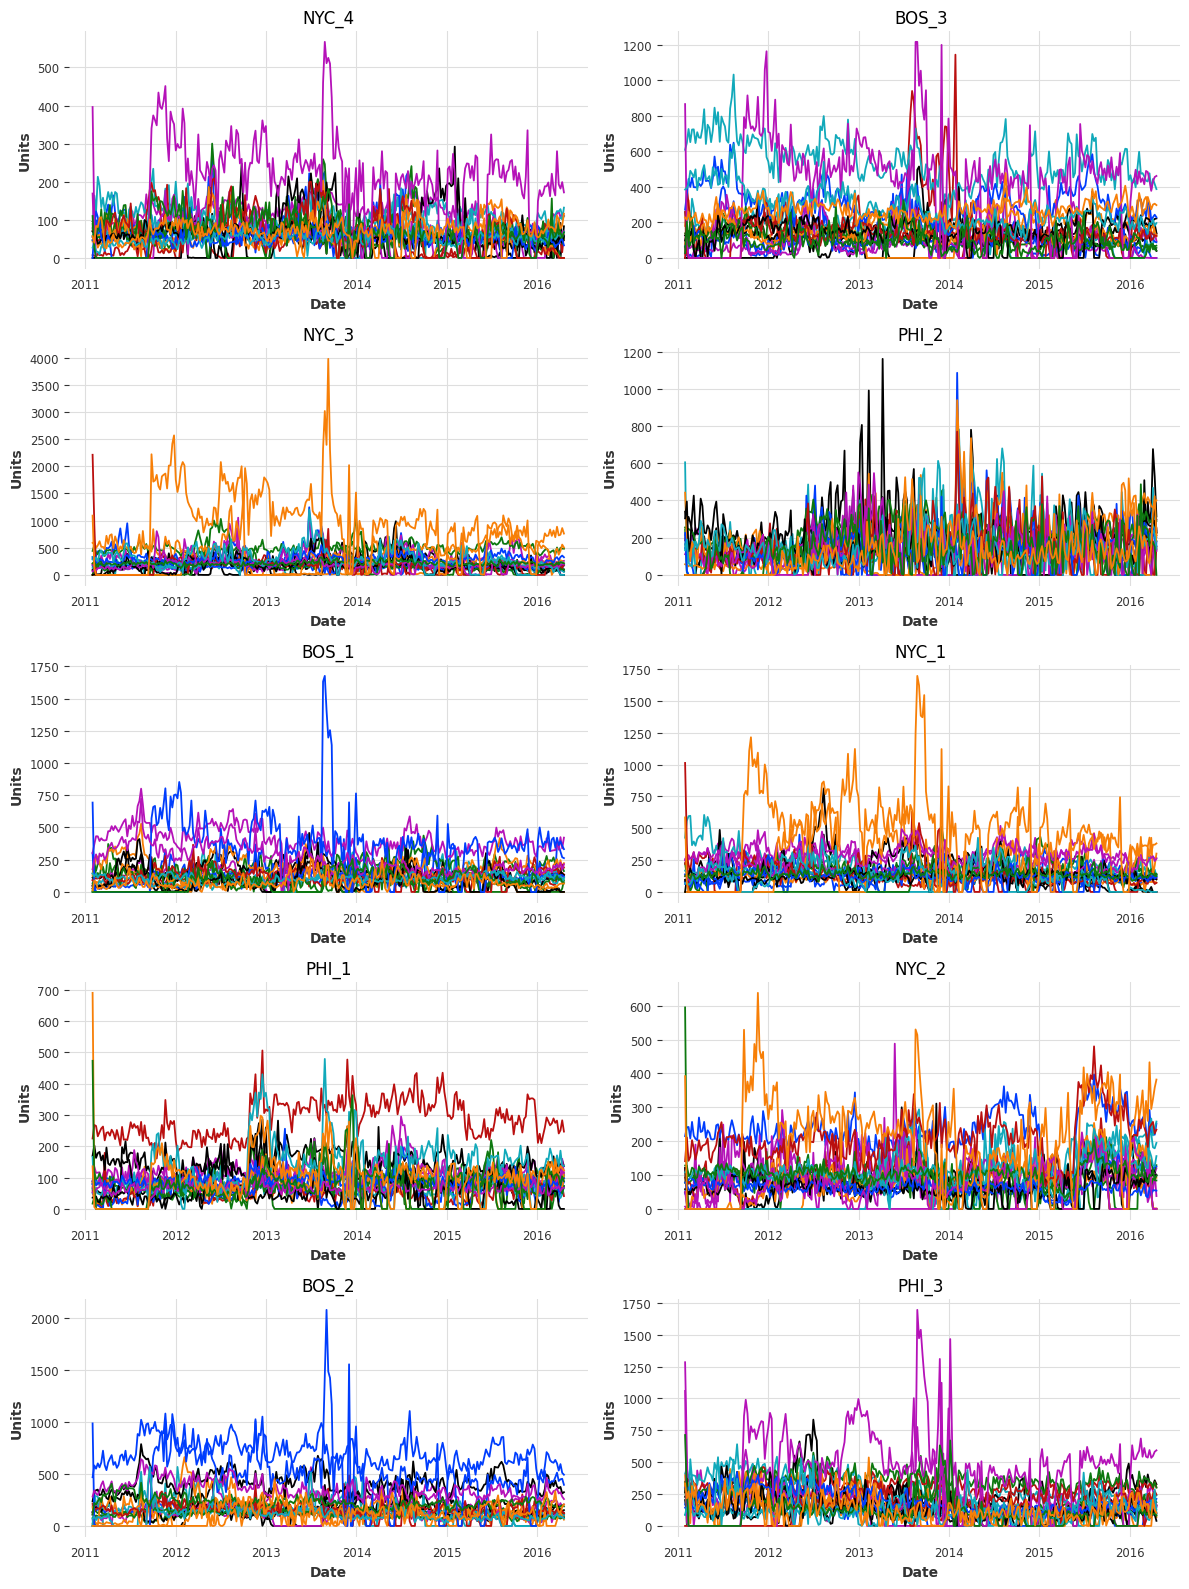

In [19]:
# Crear lista de tiendas
store_list = df_top20['store_code'].unique()

# Plotear todas las time series agrupadas por store:
fig, axs = plt.subplots(5, 2, figsize=(12, 16))
axs = axs.flatten()

for i, store_code in enumerate(store_list):
    item_data = df_top20[df_top20['store_code'] == store_code]
    ax = axs[i]
    for item in item_data['id'].unique():
        item_subset = item_data[item_data['id'] == item]
        ax.plot(item_subset['date'], item_subset['units'], label=item)
    ax.set_xlabel('Date')
    ax.set_ylabel('Units')
    ax.set_title(store_code)
    ax.grid(True)

fig.tight_layout()
plt.show()


In [20]:
df_ts = df_top20.copy()

In [21]:
df_ts.head()

,date,year,year_week,id,item,department,category,store,store_code,region,units
473928,2011-01-31,2011,2011-5,ACCESORIES_1_178_NYC_4,ACCESORIES_1_178,ACCESORIES_1,ACCESORIES,Brooklyn,NYC_4,New York,95
7729176,2011-01-31,2011,2011-5,SUPERMARKET_3_607_BOS_3,SUPERMARKET_3_607,SUPERMARKET_3,SUPERMARKET,Back_Bay,BOS_3,Boston,0
7729995,2011-01-31,2011,2011-5,SUPERMARKET_3_607_NYC_3,SUPERMARKET_3_607,SUPERMARKET_3,SUPERMARKET,Tribeca,NYC_3,New York,0
5969964,2011-01-31,2011,2011-5,SUPERMARKET_2_360_PHI_2,SUPERMARKET_2_360,SUPERMARKET_2,SUPERMARKET,Yorktown,PHI_2,Philadelphia,0
7805070,2011-01-31,2011,2011-5,SUPERMARKET_3_635_BOS_1,SUPERMARKET_3_635,SUPERMARKET_3,SUPERMARKET,South_End,BOS_1,Boston,51


In [22]:
df_ts.to_csv('real_data_2025-12-03.csv', index=False)

## Holt Winters

In [23]:
# Convertir la columna 'date' a formato datetime si no está en ese formato ya
df_ts['date'] = pd.to_datetime(df_ts['date'])

In [24]:
# Crear un diccionario para almacenar los modelos, pronósticos y métricas de rendimiento para cada ID y parámetros
models_dict = {}
forecasts_dict = {}
scores_dict = {}

best_models_dict = {}
best_scores_dict = {}

In [25]:
# Definir los parámetros de búsqueda del Holt-Winters
param_grid = {
    'trend': ['add', None], #'mul',
    'seasonal': ['add', None], #'mul', 
    'seasonal_periods': [3, 4, 5, 6, 12, 24, 48, 52]  # Puedes agregar más valores si deseas probar diferentes períodos estacionales
}

In [27]:
from itertools import product
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from darts import TimeSeries

best_scores_dict = {}
best_models_dict = {}

# Iterar sobre todas las combinaciones de parámetros
for trend, seasonal, seasonal_periods in product(
    param_grid['trend'],
    param_grid['seasonal'],
    param_grid['seasonal_periods']
):
    for group_id, group_data in df_ts.groupby('id'):

        # Asegurar índice fecha sin modificar el df original
        group_data = group_data.set_index('date')

        # Crear el TimeSeries object para el grupo actual
        time_series = TimeSeries.from_dataframe(group_data, value_cols='units')

        # Utilizar las últimas 4 filas para el conjunto de prueba
        train_data = time_series[:-4]
        test_data = time_series[-4:]

        # Evitar log de valores no positivos
        small_number = 0.01
        
        # TimeSeries -> numpy array
        train_data_np = train_data.values().squeeze()
        train_data_np = np.log1p(train_data_np + small_number)

        # Definir el modelo Holt-Winters con los parámetros actuales
        model = ExponentialSmoothing(
            endog=train_data_np,
            trend=trend,
            seasonal=seasonal,
            seasonal_periods=seasonal_periods
        )

        # Ajustar el modelo
        try:
            model_fit = model.fit()
        except Exception as e:
            print(
                f"Failed to fit model for group {group_id} with parameters: "
                f"trend={trend}, seasonal={seasonal}, seasonal_periods={seasonal_periods}."
            )
            print(f"Error: {e}")
            continue

        # Generar predicciones (4 pasos)
        try:
            predictions = model_fit.forecast(steps=4)
        except Exception as e:
            print(
                f"Failed to generate forecasts for group {group_id} with parameters: "
                f"trend={trend}, seasonal={seasonal}, seasonal_periods={seasonal_periods}."
            )
            print(f"Error: {e}")
            continue

        # Inversa del log1p
        predictions = np.expm1(predictions)

        # Test en formato numpy
        test_data_np = test_data.values().squeeze()

        # Calcular RMSE
        mse = mean_squared_error(test_data_np, predictions)
        rmse = np.sqrt(mse)

        # Guardar mejor modelo por grupo
        if group_id not in best_scores_dict or rmse < best_scores_dict[group_id]:
            best_scores_dict[group_id] = rmse
            best_models_dict[group_id] = {
                'model': model_fit,
                'trend': trend,
                'seasonal': seasonal,
                'seasonal_periods': seasonal_periods,
                'predictions': predictions
            }


In [28]:
# Luego, cuando estés guardando los modelos y las predicciones:
# Obtener la fecha de hoy en el formato deseado (por ejemplo, YYYY-MM-DD)
today_date = datetime.today().strftime('%Y-%m-%d')

# Crear una carpeta con el nombre que incluye la fecha de hoy para almacenar los modelos y las predicciones
models_folder = f'models_{today_date}'
predictions_folder = f'predictions_{today_date}'

if not os.path.exists(models_folder):
    os.makedirs(models_folder)

if not os.path.exists(predictions_folder):
    os.makedirs(predictions_folder)

# Guardar los mejores modelos y predicciones en las carpetas con la fecha de hoy
for group_id, model_info in best_models_dict.items():
    model_filename = f'model_best_trend_{model_info["trend"]}_seasonal_{model_info["seasonal"]}_periods_{model_info["seasonal_periods"]}_ID_{group_id}.pkl'
    prediction_filename = f'predictions_best_trend_{model_info["trend"]}_seasonal_{model_info["seasonal"]}_periods_{model_info["seasonal_periods"]}_ID_{group_id}.csv'
    model_info['model'].save(os.path.join(models_folder, model_filename))
    pd.DataFrame(model_info['predictions']).to_csv(os.path.join(predictions_folder, prediction_filename))

In [29]:
def calculate_mape(y_true, y_pred):
    """
    Calcula el Mean Absolute Percentage Error (MAPE) entre las predicciones y los valores reales.

    Args:
        y_true (array-like): Array o lista de los valores reales.
        y_pred (array-like): Array o lista de las predicciones del modelo.

    Returns:
        float: El valor del MAPE.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [31]:
rows = []

for group_id, model_info in best_models_dict.items():
    rows.append({
        'ID': group_id,
        'Trend': model_info["trend"],
        'Seasonal': model_info["seasonal"],
        'Seasonal_Periods': model_info["seasonal_periods"],
        'RMSE': best_scores_dict[group_id],
        'MAPE': calculate_mape(test_data_np, model_info['predictions'])
    })

metrics_df = pd.concat([metrics_df, pd.DataFrame(rows)], ignore_index=True)

metrics_df.to_csv(f'metrics_{today_date}_012.csv', index=False)


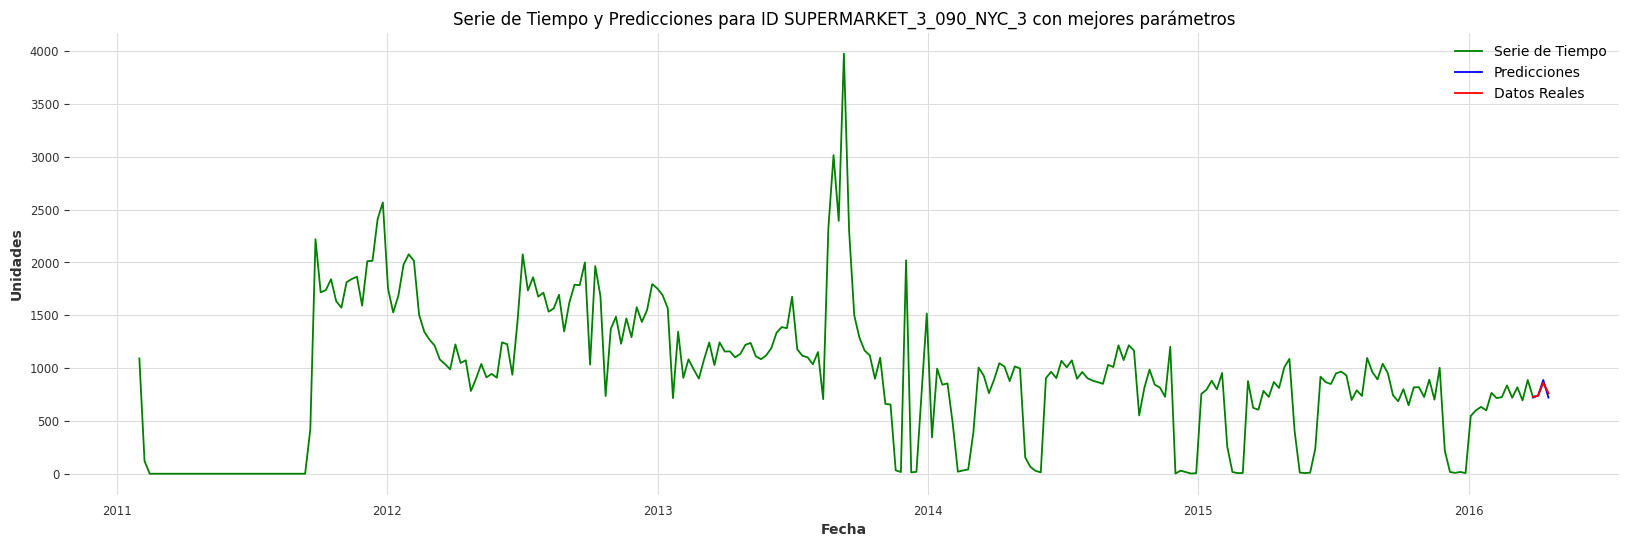

In [32]:
# ID para el que deseas visualizar las predicciones
selected_id = "SUPERMARKET_3_090_NYC_3"  # Cambiar por el ID deseado

# Obtener las fechas de las predicciones (últimos 4 pasos)
dates = df_ts[df_ts['id'] == selected_id]['date'][-4:]

# Obtener las predicciones para el ID seleccionado con los mejores parámetros
# Obtener el mejor modelo y las predicciones para el ID seleccionado
model_info = best_models_dict[selected_id]
best_model = model_info['model']
best_predictions = model_info['predictions']

# Obtener los datos reales para el ID seleccionado (últimos 4 pasos)
real_data = df_ts[df_ts['id'] == selected_id]['units'][-4:]

# Crear un DataFrame con todas las fechas y las predicciones
all_dates = df_ts[df_ts['id'] == selected_id]['date']
all_predictions = best_model.forecast(steps=len(all_dates))
all_predictions = np.expm1(all_predictions)  # Aplicar transformación inversa

# Crear un plot para visualizar la serie de tiempo completa y las predicciones
plt.figure(figsize=(20, 6))
plt.plot(all_dates, df_ts[df_ts['id'] == selected_id]['units'], label='Serie de Tiempo', color='green')
plt.plot(dates, best_predictions, label='Predicciones', color='blue')
plt.plot(dates, real_data, label='Datos Reales', color='red')
plt.xlabel('Fecha')
plt.ylabel('Unidades')
plt.title(f'Serie de Tiempo y Predicciones para ID {selected_id} con mejores parámetros')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
# fechas de fin
end_date = df_ts['date'].iloc[-1]

# Calcular la fecha de inicio restando 3 semanas a la fecha de finalización
start_date = end_date - timedelta(weeks=3)

# número de semanas entre las fechas
num_weeks = (end_date - start_date).days // 7

# lista de todas las fechas en el rango
dates = [start_date + timedelta(weeks=x) for x in range(num_weeks+1)]

In [34]:
end_date

Timestamp('2016-04-18 00:00:00')

In [35]:
start_date

Timestamp('2016-03-28 00:00:00')

In [36]:
dates

[Timestamp('2016-03-28 00:00:00'),
 Timestamp('2016-04-04 00:00:00'),
 Timestamp('2016-04-11 00:00:00'),
 Timestamp('2016-04-18 00:00:00')]

In [38]:
# Obtén una lista de todos los archivos csv en el directorio
all_files = glob.glob('./predictions_2025-12-03/*.csv')

# Crea una lista de dataframes
list_df = []

for filename in all_files:
    # Obtiene el ID del nombre del archivo
    id = filename.split('_ID_')[1].split('.csv')[0]

    # Selecciona la serie de tiempo correspondiente al ID del DataFrame original
    ts = df_ts[df_ts['id'] == id]

    # Encuentra la fecha final de las predicciones
    end_date = ts['date'].iloc[-1]
    
    # Calcula la fecha de inicio restando 3 semanas a la fecha final
    start_date = end_date - timedelta(weeks=3)

    # número de semanas entre las fechas
    num_weeks = (end_date - start_date).days // 7

    # lista de todas las fechas en el rango
    date_range = [start_date + timedelta(weeks=x) for x in range(num_weeks+1)]

    # Lee el archivo csv actual
    df = pd.read_csv(filename, index_col=None, header=0)

    # Agrega la columna de fechas al DataFrame
    df['date'] = date_range

    # Agrega la columna de id al DataFrame
    df['id'] = id

    # Agrega el DataFrame a la lista
    list_df.append(df)

# Concatena todos los dataframes en uno solo
df_predictions_combined = pd.concat(list_df, axis=0, ignore_index=True)

# Reorganiza las columnas
df_predictions_combined = df_predictions_combined[['id', 'date', '0']]

# Guarda el dataframe combinado en un archivo CSV
df_predictions_combined.to_csv('combined_predictions_2023-07-22_012.csv', index=False)